In [1]:
# By default in a Jupyter notebook, a cell with multiple print commands, when run, would print only the last one. 
# This piece of code would modify that to print all the relevant lines in the cell.  
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Demonstration of the Non-linear curve fitting in Python

### Import relevant libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import scipy.optimize as opt
import math

import warnings
np.set_printoptions(precision=3, suppress=True)

### Load and visualize data

In [3]:
# Load data
indata = pd.read_csv("michaelis-menten-example.csv")
print("indata : " + str(indata.shape))

indata : (12, 2)


In [4]:
indata.head()

,concentration,velocity
0,0.02,47
1,0.02,76
2,0.06,97
3,0.06,107
4,0.11,123


Text(0.5, 1.0, 'Bi-variate Scatter Plot')

Text(0.5, 0, 'Concentration in ppm')

Text(0, 0.5, 'velocity')

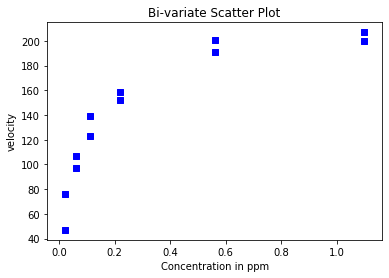

In [5]:
plt.scatter(indata["concentration"], indata["velocity"], c = "blue", marker = "s")
plt.title("Bi-variate Scatter Plot")
plt.xlabel("Concentration in ppm")
plt.ylabel("velocity")
plt.show()

### Transform the x and y by taking inverse function and fitting a linear regression

Text(0.5, 1.0, 'Bi-variate Scatter Plot')

Text(0.5, 0, '1/Concentration in ppm')

Text(0, 0.5, '1/velocity')

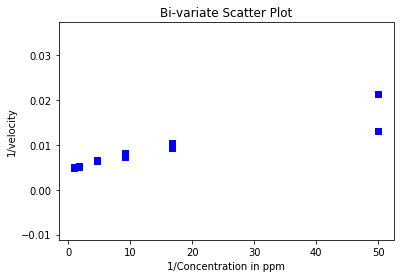

In [6]:
y_ = 1/indata["velocity"]
x_ = 1/indata["concentration"]
plt.scatter(x_, y_, c = "blue", marker = "s")
plt.title("Bi-variate Scatter Plot")
plt.xlabel("1/Concentration in ppm")
plt.ylabel("1/velocity")
plt.show()

In [8]:
X_ = sm.add_constant(x_) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y_, X_).fit() ## sm.OLS(output, input)
predictions = model.predict(X_)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               velocity   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     59.30
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           1.64e-05
Time:                        19:43:26   Log-Likelihood:                 59.306
No. Observations:                  12   AIC:                            -114.6
Df Residuals:                      10   BIC:                            -113.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0051      0.001      7.255      0.000       0.004       0.007
concentration     0.0002   3.21e-05      7.700      0.000       0.000       0.000
==============================================================================
Omnibus:                        6.149   Durbin-Watson:                   2.733
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                2.747
Skew:                          -0.379   Prob(JB):                        0.253
Kurtosis:                       5.218   Cond. No.                         28.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Actuals vs Regression Line')

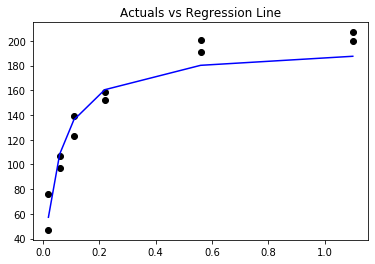

In [9]:
plt.plot(indata["concentration"], indata["velocity"], 'o', color='black');
plt.plot(1/x_,1/predictions,color='blue')

plt.title("Actuals vs Regression Line")

### Fit a non-linear model

In [15]:
x = indata["concentration"]
y = indata["velocity"]

def func(x, theta1, theta2): 
    return  (theta1 * x) / (x + theta2) 


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(x, *parameterTuple)
    return np.sum((y - val) ** 2.0)


def generate_Initial_Parameters():

    parameterBounds = []
    parameterBounds.append([0, 300]) 
    parameterBounds.append([0, 300]) 
    
    # "seed" the numpy random number generator for repeatable results
    result = opt.differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = opt.curve_fit(func, x, y, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(x, *fittedParameters) 

absError = modelPredictions - y

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(y))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

Parameters [212.684   0.064]
RMSE: 9.981018712366811
R-squared: 0.9615614016321399


In [16]:
geneticParameters

array([212.684,   0.064])

In [17]:
print(SE.sum()/(12-2))

# This is sigma^2 * (Z'Z)^-1 
print(pcov)

print('SE(theta1) :', math.sqrt(pcov[0,0]))
print('SE(theta2) :', math.sqrt(pcov[1,1]))
print('Corr(theta1,theta2) :', pcov[1,0]/math.sqrt(pcov[1,1]*pcov[0,0]))

119.54488144393974
[[48.263  0.044]
 [ 0.044  0.   ]]
SE(theta1) : 6.947153568067284
SE(theta2) : 0.008280945269656559
Corr(theta1,theta2) : 0.7650836577867206


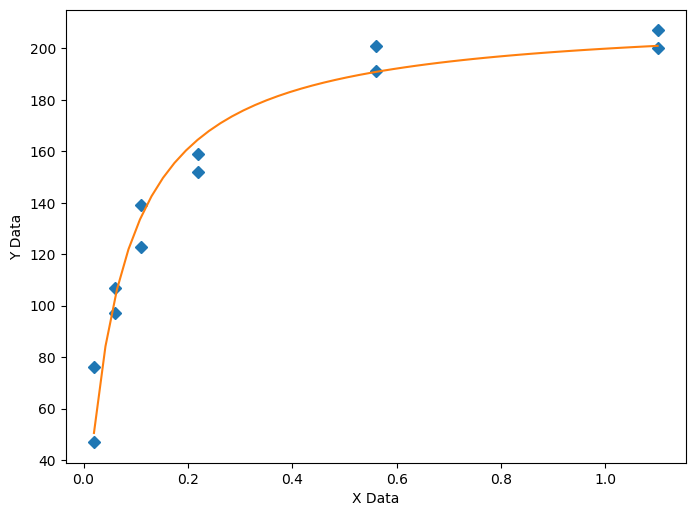

In [18]:
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(x, y,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(x), max(x))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

## Logistic Regression

### Load and Visualize Data

In [19]:
# Load data
indata = pd.read_csv("riding-mower-example.csv")
print("indata : " + str(indata.shape))
indata.head()

indata : (24, 4)


,ID,income,lotsize,Owner
0,1,60.0,18.4,1
1,2,85.5,16.8,1
2,3,64.8,21.6,1
3,4,61.5,20.8,1
4,5,87.0,23.6,1


In [20]:
cols_to_keep = [ 'Owner', 'income', 'lotsize']
indata = indata[cols_to_keep]
indata.insert(1, 'intercept_dummy', 1)
indata.head()

,Owner,intercept_dummy,income,lotsize
0,1,1,60.0,18.4
1,1,1,85.5,16.8
2,1,1,64.8,21.6
3,1,1,61.5,20.8
4,1,1,87.0,23.6


In [157]:
model = sm.GLM.from_formula('Owner ~ income + lotsize',
                            data=indata, family=sm.families.Binomial())
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Owner   No. Observations:                   24
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.6616
Date:                Wed, 02 Dec 2020   Deviance:                       15.323
Time:                        04:06:47   Pearson chi2:                     14.3
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.9382     11.487     -2.258      0.024     -48.452      -3.424
income         0.1109      0.054      2.042      0.041       0.004       0.217
lotsize        0.9638      0.463      2.083      0.037       0.057       1.871
==============================================================================
"""

In [159]:

def f(beta, y, x):
    return -((-np.log(1 + np.exp(np.dot(x, beta)))).sum() + (y*(np.dot(x, beta))).sum())

beta0 = np.zeros(3)


In [160]:
opt.minimize(f, beta0, args=(indata['Owner'], indata.loc[:,"intercept_dummy":]), method='BFGS', options={'gtol':1e-2})

      fun: 7.661640308030567
 hess_inv: array([[ 1.06787426e+02, -4.14145571e-01, -4.06598937e+00],
       [-4.14145571e-01,  2.66848122e-03,  1.21047495e-02],
       [-4.06598937e+00,  1.21047495e-02,  1.68486274e-01]])
      jac: array([5.19752502e-05, 4.63509560e-03, 3.00645828e-04])
  message: 'Optimization terminated successfully.'
     nfev: 100
      nit: 17
     njev: 20
   status: 0
  success: True
        x: array([-25.93500665,   0.11085101,   0.96363979])

In [161]:
opt.minimize(f, beta0, args=(indata['Owner'], indata.loc[:,"intercept_dummy":]), method='Nelder-Mead', options={'gtol':1e-2})

 final_simplex: (array([[-25.93818915,   0.11085843,   0.96377769],
       [-25.93825711,   0.11085867,   0.9637799 ],
       [-25.93813162,   0.11085841,   0.96377466],
       [-25.93812632,   0.11085797,   0.96377596]]), array([7.66164026, 7.66164026, 7.66164026, 7.66164026]))
           fun: 7.661640261125125
       message: 'Optimization terminated successfully.'
          nfev: 268
           nit: 154
        status: 0
       success: True
             x: array([-25.93818915,   0.11085843,   0.96377769])

In [ ]:
opt.minimize(f, beta0, args=(indata['Owner'], indata.loc[:,"intercept_dummy":]), method='BFGS', options={'gtol':1e-2})

#### Alternate Method

In [21]:
def f(X, weight):
    z = np.dot(X, weight)
    return 1 / (1 + np.exp(-z))


def objective_fun(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

def gradient_descent(X, h, y):
    return np.dot(X.T, (h - y)) / y.shape[0]

def update_weight_loss(weight, learning_rate, gradient):
    return weight - learning_rate * gradient



def log_likelihood(x, y, weights):
    z = np.dot(x, weights)
    ll = np.sum( y*z - np.log(1 + np.exp(z)) )
    return ll

def gradient_ascent(X, h, y):
    return np.dot(X.T, y - h)

def update_weight_mle(weight, learning_rate, gradient):
    return weight + learning_rate * gradient

In [22]:
import time

start_time = time.time()

num_iter = 1000

X = indata.loc[:,"intercept_dummy":]
y= indata['Owner']
beta = np.zeros(3)

for i in range(num_iter):
    h = f(X, beta)
    gradient = gradient_descent(X, h, y)
    beta = update_weight_loss(beta, 0.1, gradient)
    
print("Training time (Log Reg using Gradient descent):" + str(time.time() - start_time) + " seconds")
print("Learning rate: {}\nIteration: {}".format(0.1, num_iter))

Training time (Log Reg using Gradient descent):0.5684778690338135 seconds
Learning rate: 0.1
Iteration: 1000


In [23]:
result = f(X, beta)

In [24]:
num_iter = 1000

X_ = indata.loc[:,"intercept_dummy":]
y= indata['Owner']
beta_ = np.zeros(3)

for i in range(num_iter):
    h_ = f(X_, beta_)
    gradient_mle = gradient_ascent(X_, h_, y) 
    beta_ = update_weight_mle(beta_, 0.1, gradient_mle)
    
print("Training time (Log Reg using MLE):" + str(time.time() - start_time) + "seconds")
print("Learning rate: {}\nIteration: {}".format(0.1, num_iter))
print(beta_)

Training time (Log Reg using MLE):6.575971841812134seconds
Learning rate: 0.1
Iteration: 1000
[-109.657   37.149 -247.435]


In [ ]:
result_mle = f(X_, beta_)

In [178]:
from sklearn.linear_model import LogisticRegression
skmodel = LogisticRegression(fit_intercept=True, max_iter=1000)
skfit = skmodel.fit(indata[['income','lotsize']], y)
print("Training time (sklearn's LogisticRegression module):" + str(time.time() - start_time) + " seconds")
print("Learning rate: {}\nIteration: {}".format(0.1, num_iter))
skfit.()

Training time (sklearn's LogisticRegression module):194.12219953536987 seconds
Learning rate: 0.1
Iteration: 1000


TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

### Reference 

Generalized Linear Models by Raymond Myers, Doug Montgomery and Geoffery Vining

https://www.kaggle.com/jeppbautista/logistic-regression-from-scratch-python

https://stackoverflow.com/questions/51972637/nonlinear-regression-with-python-whats-a-simple-method-to-fit-this-data-bette

https://towardsdatascience.com/constrained-optimization-demystified-with-implementation-in-python-235639546fa9

https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
